# Open Ocean Ship Track Analysis  
Similar to the LA Port analysis, here we examine the graphical representation of ships traversing open ocean off of the coast of California.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import random
import datetime

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

In [2]:
# Function to draw tracks 
import descartes
import geopandas as gpd
import fiona
from shapely.geometry import Point, LineString, Polygon

%matplotlib inline

def draw_tracks(data, mmsi_list):
    data = data[data.MMSI.isin(mmsi_list)]
    points = [Point(x, y) for x, y in zip(data.LON, data.LAT)]
    points_df = gpd.GeoDataFrame(data, geometry=points, crs ="EPSG:4326")

    # treat each `ID` group of points as a line
    lines = points_df.groupby(['MMSI'])['geometry'].apply(lambda x:  LineString(x.tolist()))
    
    # store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
    lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326") 
    lines.reset_index(inplace=True)
    lines.plot(column='MMSI', categorical=True, legend=True)

def draw_all_tracks(data):
    all_ships = list(data.columns.values)
    draw_tracks(data, all_ships)

def prepare_data_for_vis(data):
    uniques = np.unique(data.MMSI, return_counts=True)
    index_to_remove = list(np.where(uniques[1] == 1)[0])
    to_remove = uniques[0][index_to_remove]
    return data[data.MMSI.isin(to_remove) == False]

In [3]:
full_ocean_data = pd.read_csv("../data/AIS_open_ocean.csv")

### Cleaning the data  
Clean the data so that we are only working with cargo and tanker ships that are moving.

In [4]:
cols = ["MMSI", "BaseDateTime", "LAT", "LON", "SOG", "COG", "Heading", 'VesselType']
ocean_data = full_ocean_data[cols]

In [5]:
ocean_data = ocean_data.copy()[(ocean_data.VesselType >= 70) & (ocean_data.VesselType < 90)]
ocean_data.drop(columns=['VesselType'], axis=1, inplace=True)

In [6]:
# Convert time string to timestamp
ocean_data['BaseDateTime'] = pd.to_datetime(ocean_data['BaseDateTime'], format='%Y-%m-%dT%H:%M:%S')

In [21]:
# Drop tracks in ocean data with only a single record
counts = (ocean_data.groupby("MMSI").count().COG == 1)
singles = counts[counts].index.values
ocean_data = ocean_data[~ocean_data.MMSI.isin(singles)]

In [22]:
# Remove entries where the ship is not moving
ocean_data = ocean_data[ocean_data.SOG != 0]
cog_ocean = ocean_data.reset_index(drop=True)
cog_ocean.drop(['LAT', 'LON', 'SOG', 'Heading'], axis=1, inplace=True)

## Creating the first graph of tracks

In [23]:
data = cog_ocean.copy()
data = data.set_index('BaseDateTime')
data = data.sort_index()

In [24]:
tracks = data.pivot_table(values='COG', index=data.index, columns='MMSI', aggfunc='first')
tracks = tracks.fillna(0)

In [25]:
tracks = tracks.resample("10T").mean()

  0%|          | 0/33 [00:00<?, ?it/s]

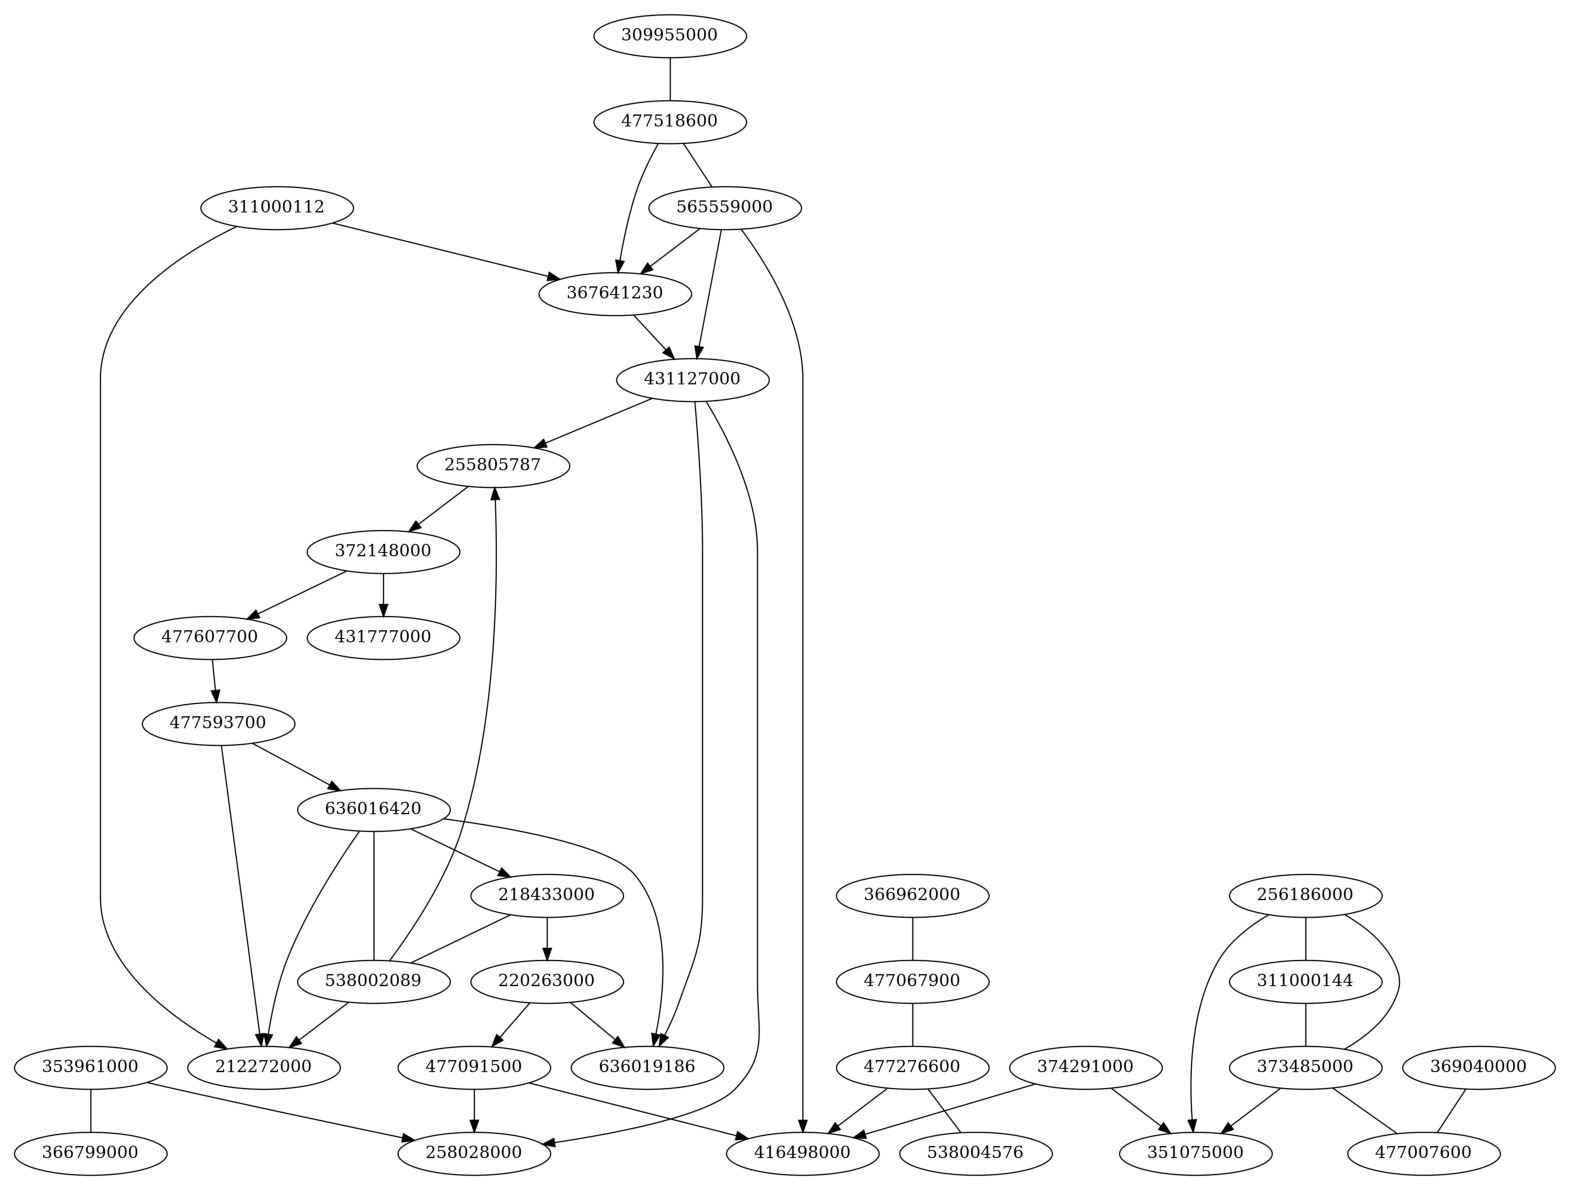

In [26]:
graph = pc(tracks.values)
cols = list(tracks.columns.values)
graph.draw_pydot_graph(labels=cols)

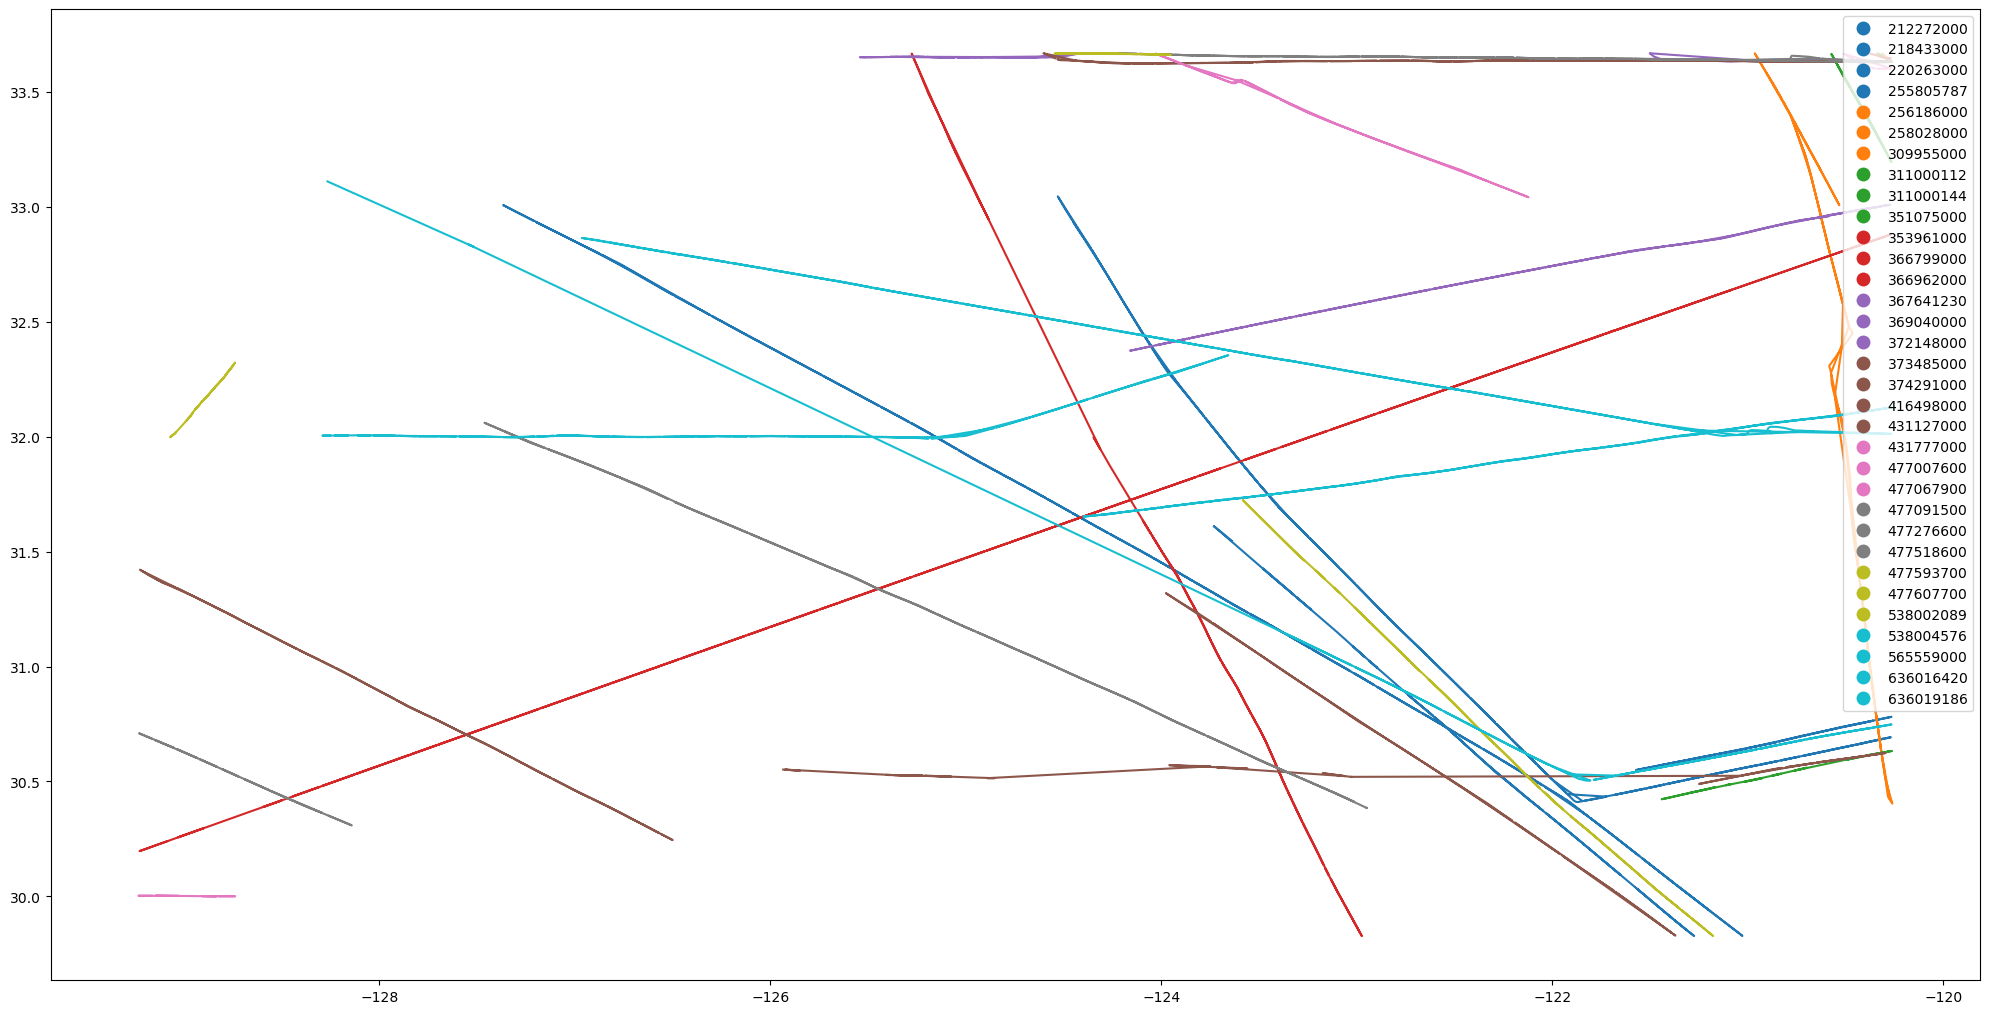

In [27]:
# All tracks shown
all_ships = list(tracks.columns.values)
draw_tracks(ocean_data, all_ships)

## Graph from a smaller time frame in the morning hours

In [28]:
start_time = datetime.datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.datetime.strptime('2020-01-01 12:00:00', '%Y-%m-%d %H:%M:%S')

mask = (tracks.index > start_time) & (tracks.index < end_time)
morning_tracks = tracks[mask]

In [29]:
# remove tracks with all constants
nunique = morning_tracks.nunique()
constant_cols = nunique[nunique == 1].index
morning_tracks = morning_tracks.drop(constant_cols, axis=1)

  0%|          | 0/21 [00:00<?, ?it/s]

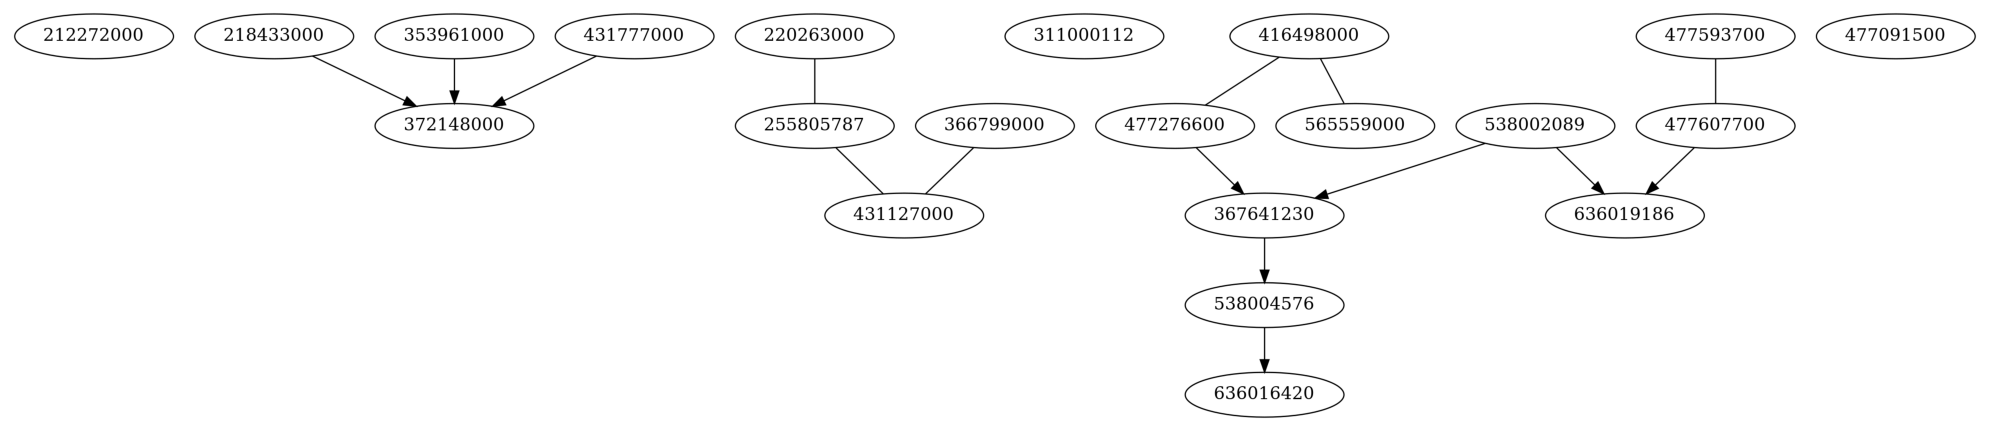

In [31]:
graph_ocean = pc(morning_tracks.values)
cols = list(morning_tracks.columns.values)
graph_ocean.draw_pydot_graph(labels=cols)

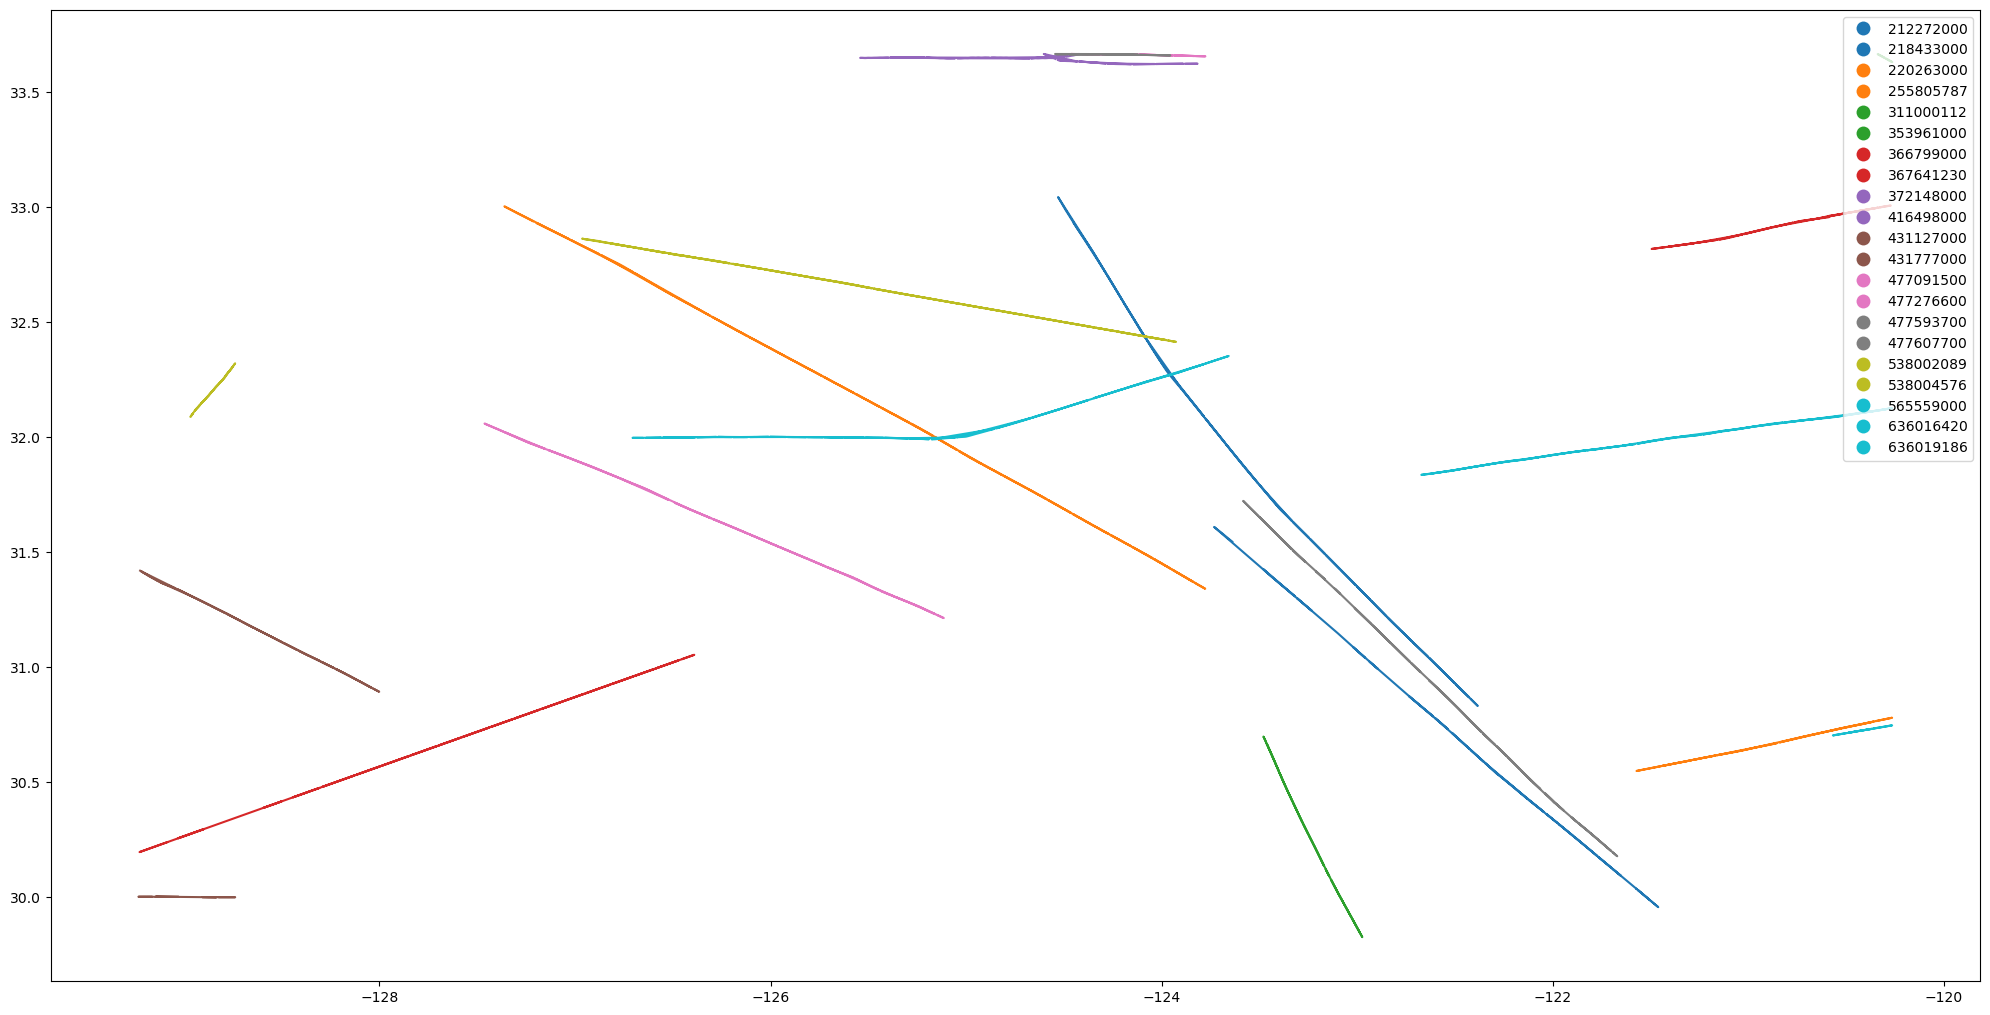

In [32]:
# Tracks for morning hours shown
morning_ocean_data = ocean_data[(ocean_data.BaseDateTime > start_time) & (ocean_data.BaseDateTime < end_time)]
morning_ocean_data = prepare_data_for_vis(morning_ocean_data)
all_ships = list(morning_tracks.columns.values)
draw_tracks(morning_ocean_data, all_ships)

**Let's examine a few tracks that are connected in the graph**

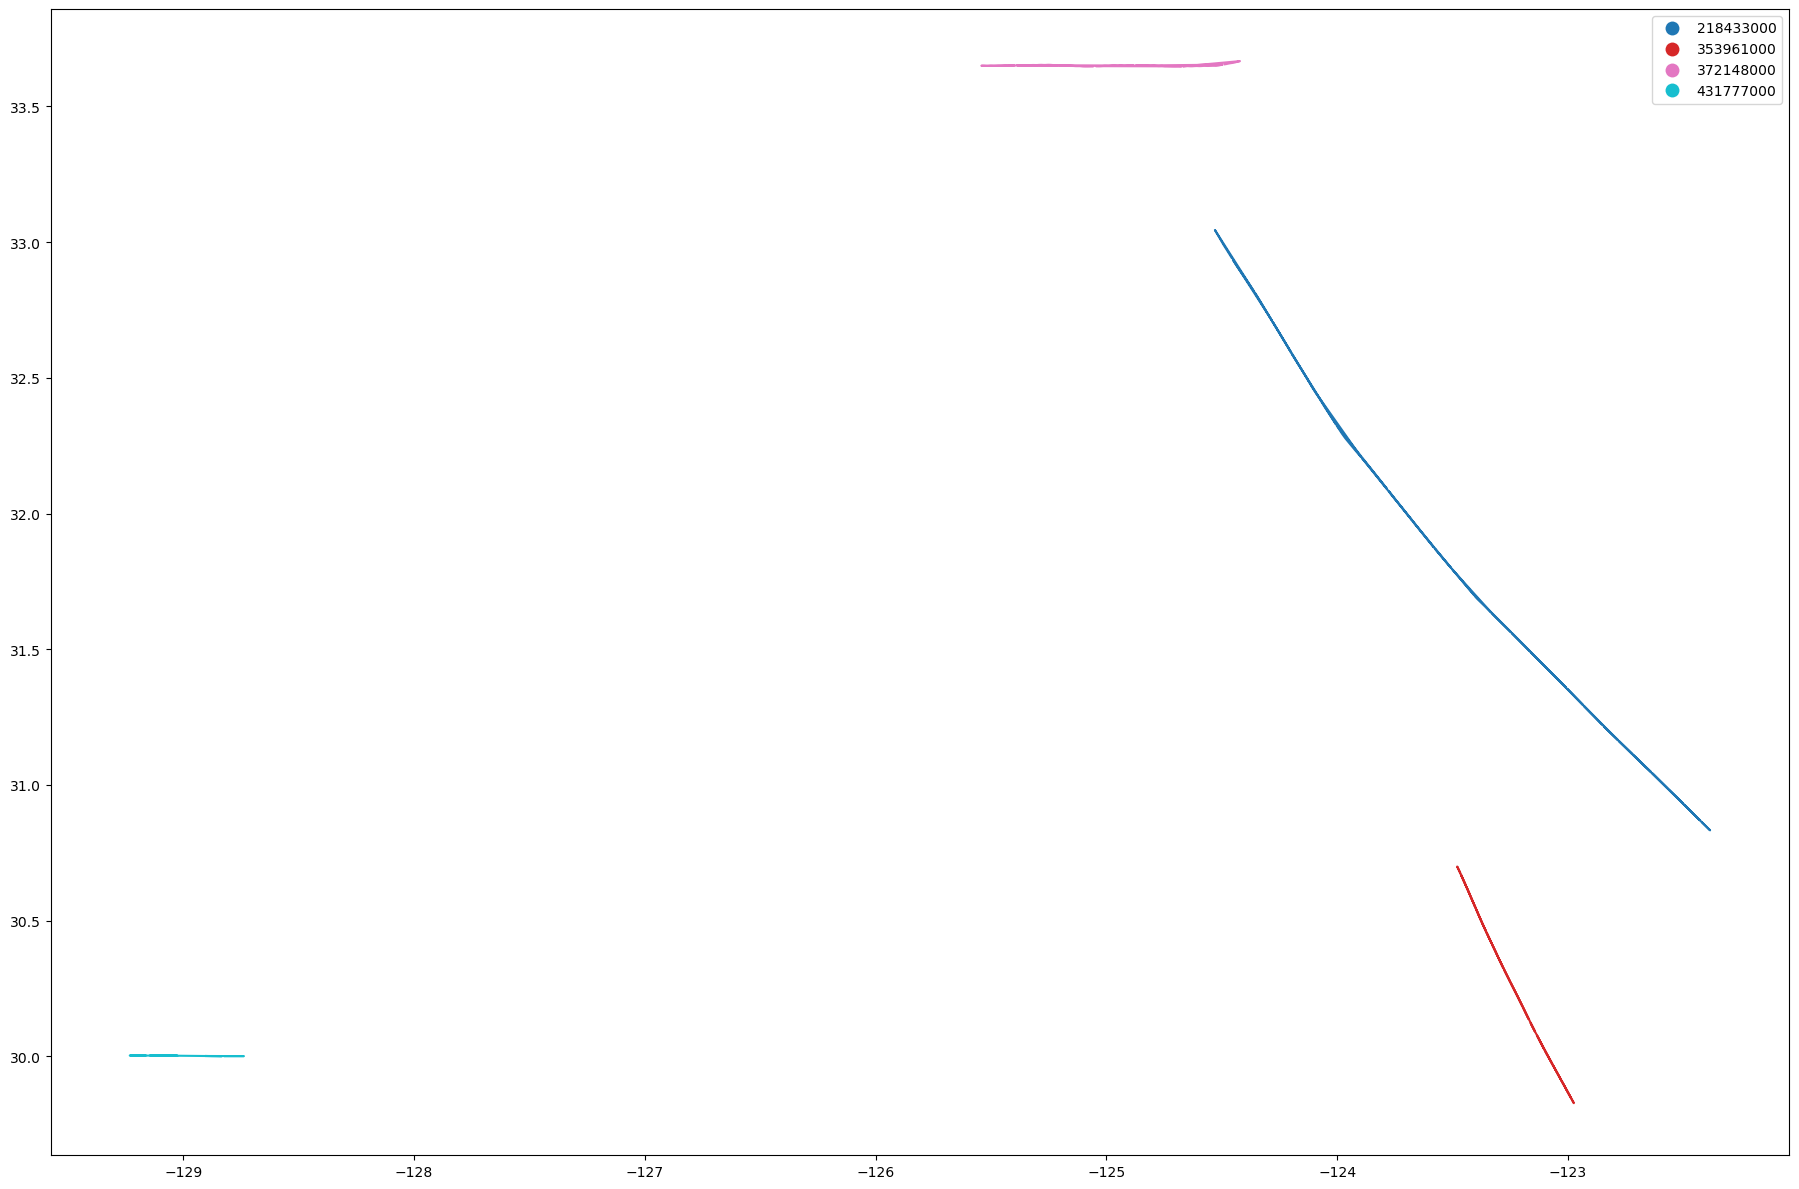

In [34]:
draw_tracks(morning_ocean_data, mmsi_list=[218433000, 353961000, 431777000, 372148000])

## Timeshift Analysis Part I  
Here, we examine what the graphical structure looks like when we take one ship and duplicate the track. We then shift the duplicated track a certain amount of time and examine the effect on the graph representation.

In [36]:
# Data cleaning and processing functions
def clean_data_processor(data):
    clean_data = data.reset_index(drop=True)
    clean_data.drop(['LAT', 'LON', 'SOG', 'Heading'], axis=1, inplace=True)
    clean_data = clean_data.copy()
    clean_data = clean_data.set_index('BaseDateTime')
    clean_data = clean_data.sort_index()
    return clean_data

def get_tracks(data, time_interval="10T"):
    tracks_data = data.pivot_table(values='COG', index=data.index, columns='MMSI', aggfunc='first')
    tracks_data = tracks_data.fillna(0)
    tracks_data = tracks_data.resample(time_interval).mean()
    return tracks_data

def get_sub_tracks(tracks_data, start_time, end_time):
    mask = (tracks_data.index > start_time) & (tracks_data.index < end_time)
    sub_tracks_data = tracks_data[mask]
    # remove tracks with all constants
    nunique = sub_tracks_data.nunique()
    constant_cols = nunique[nunique == 1].index
    sub_tracks_data = sub_tracks_data.drop(constant_cols, axis=1)
    return sub_tracks_data

def time_shift_track(shift_delta, mmsi, new_mmsi, data):
    ship = data[data.MMSI == mmsi]
    time_shift_ship = ship.copy()
    time_shift_ship.MMSI = np.full(ship.shape[0], new_mmsi)
    time_shift_ship.BaseDateTime = time_shift_ship.BaseDateTime + pd.Timedelta(minutes=shift_delta)
    time_shift_ship.reset_index(drop=True, inplace=True)
    return pd.concat([time_shift_ship, data], ignore_index=True)

def get_pc_graph(tracks_data):
    graph_ocean = pc(tracks_data.values)
    cols = list(tracks_data.columns.values)
    graph_ocean.draw_pydot_graph(labels=cols)

**Sample 1**

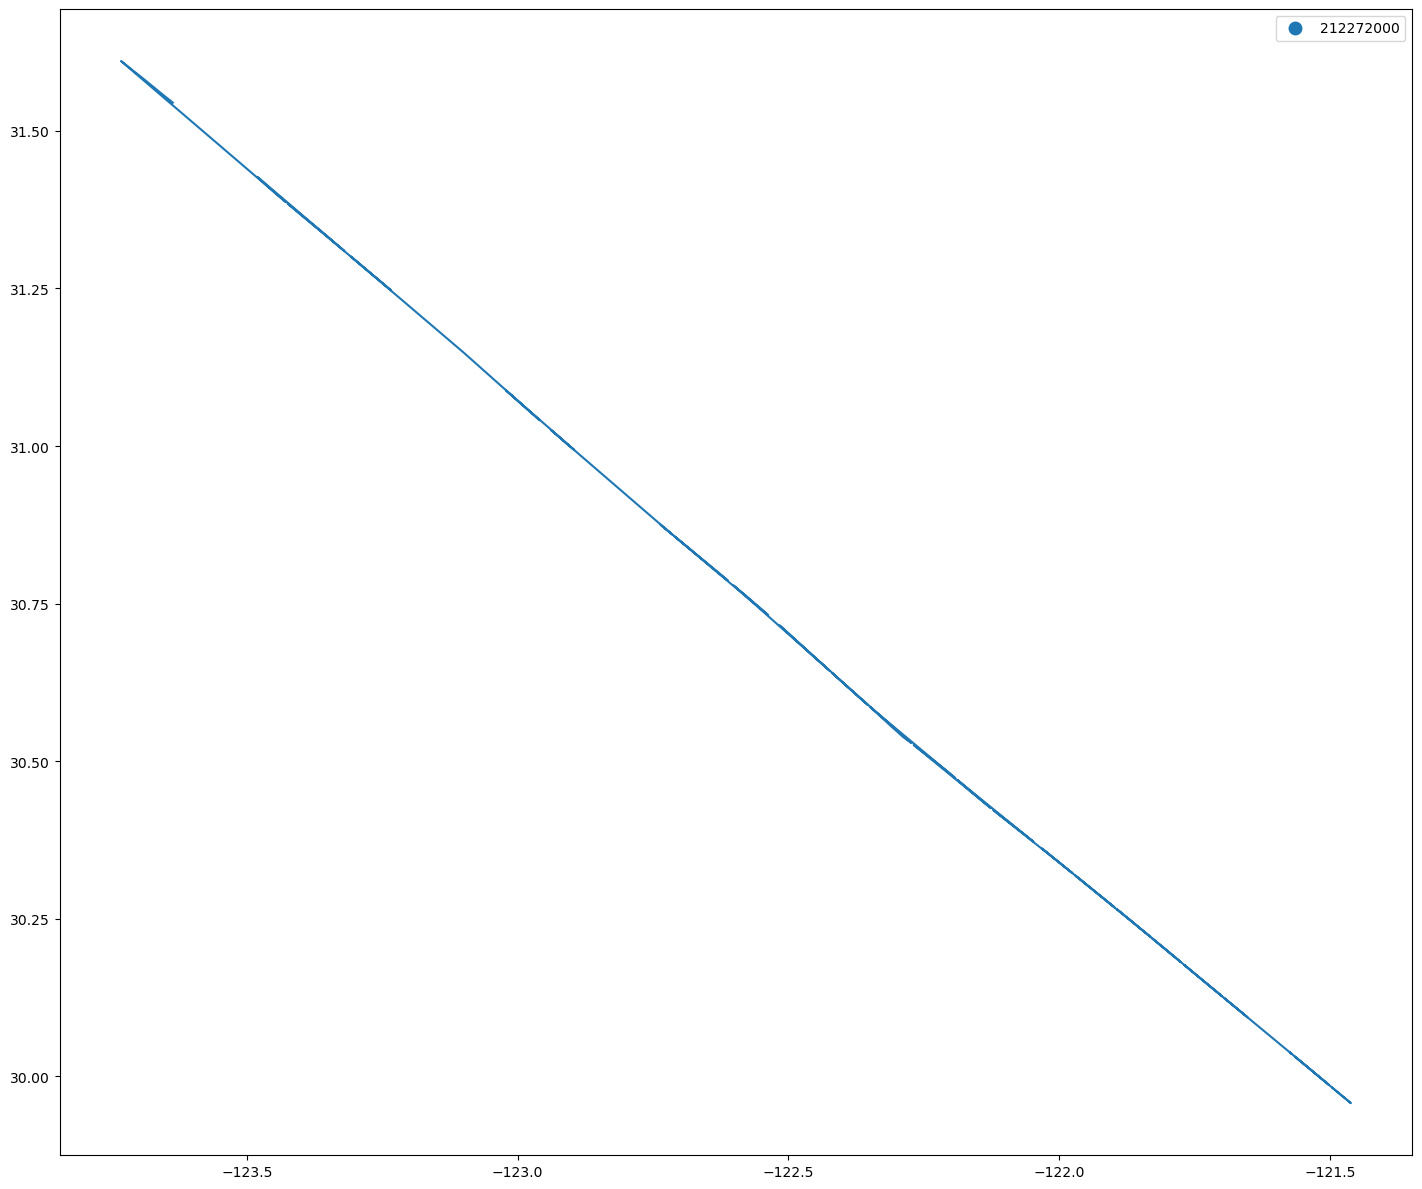

In [38]:
mmsi = 212272000
draw_tracks(morning_ocean_data, mmsi_list=[mmsi])

  0%|          | 0/26 [00:00<?, ?it/s]

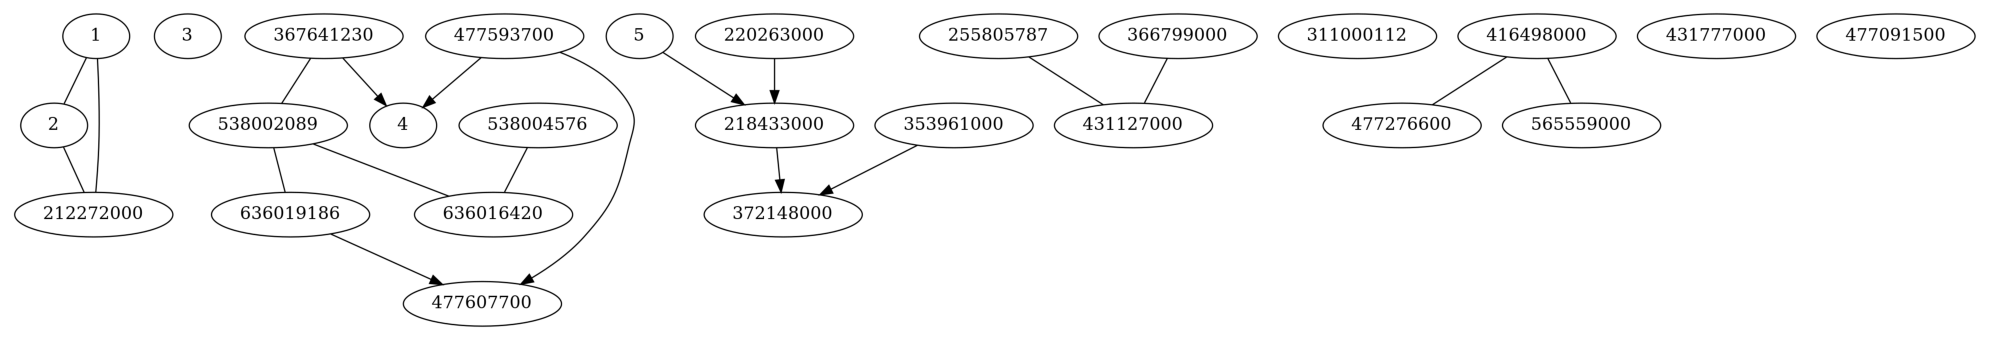

In [40]:
time_shift_ocean_data = time_shift_track(5, mmsi, 1, morning_ocean_data)
time_shift_ocean_data = time_shift_track(10, mmsi, 2, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(30, mmsi, 3, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(60, mmsi, 4, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(120, mmsi, 5, time_shift_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

**Sample 2**

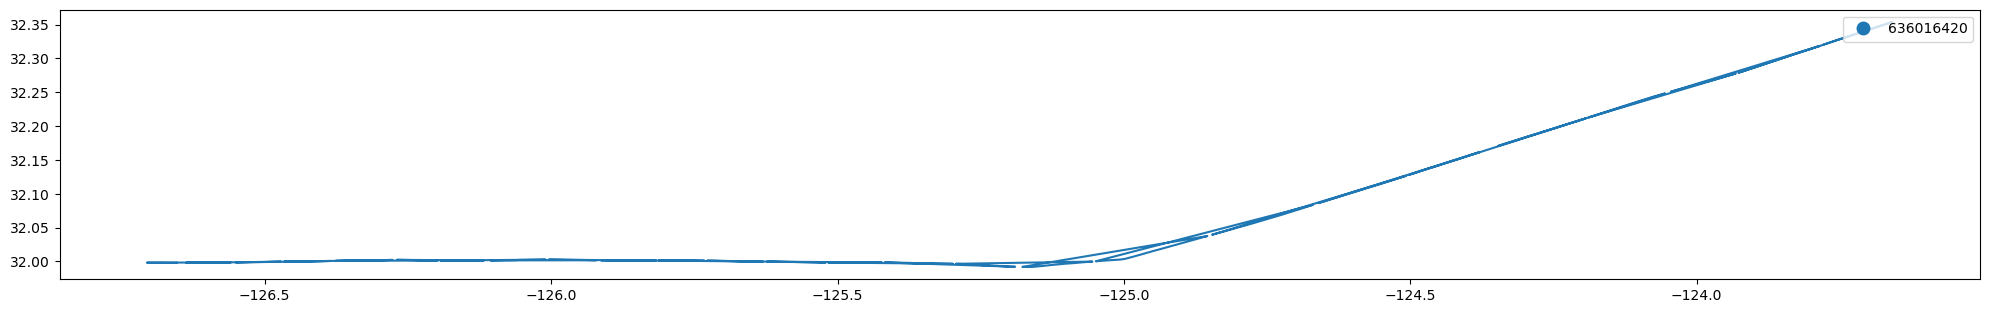

In [41]:
mmsi = 636016420
draw_tracks(morning_ocean_data, mmsi_list=[mmsi])

  0%|          | 0/26 [00:00<?, ?it/s]

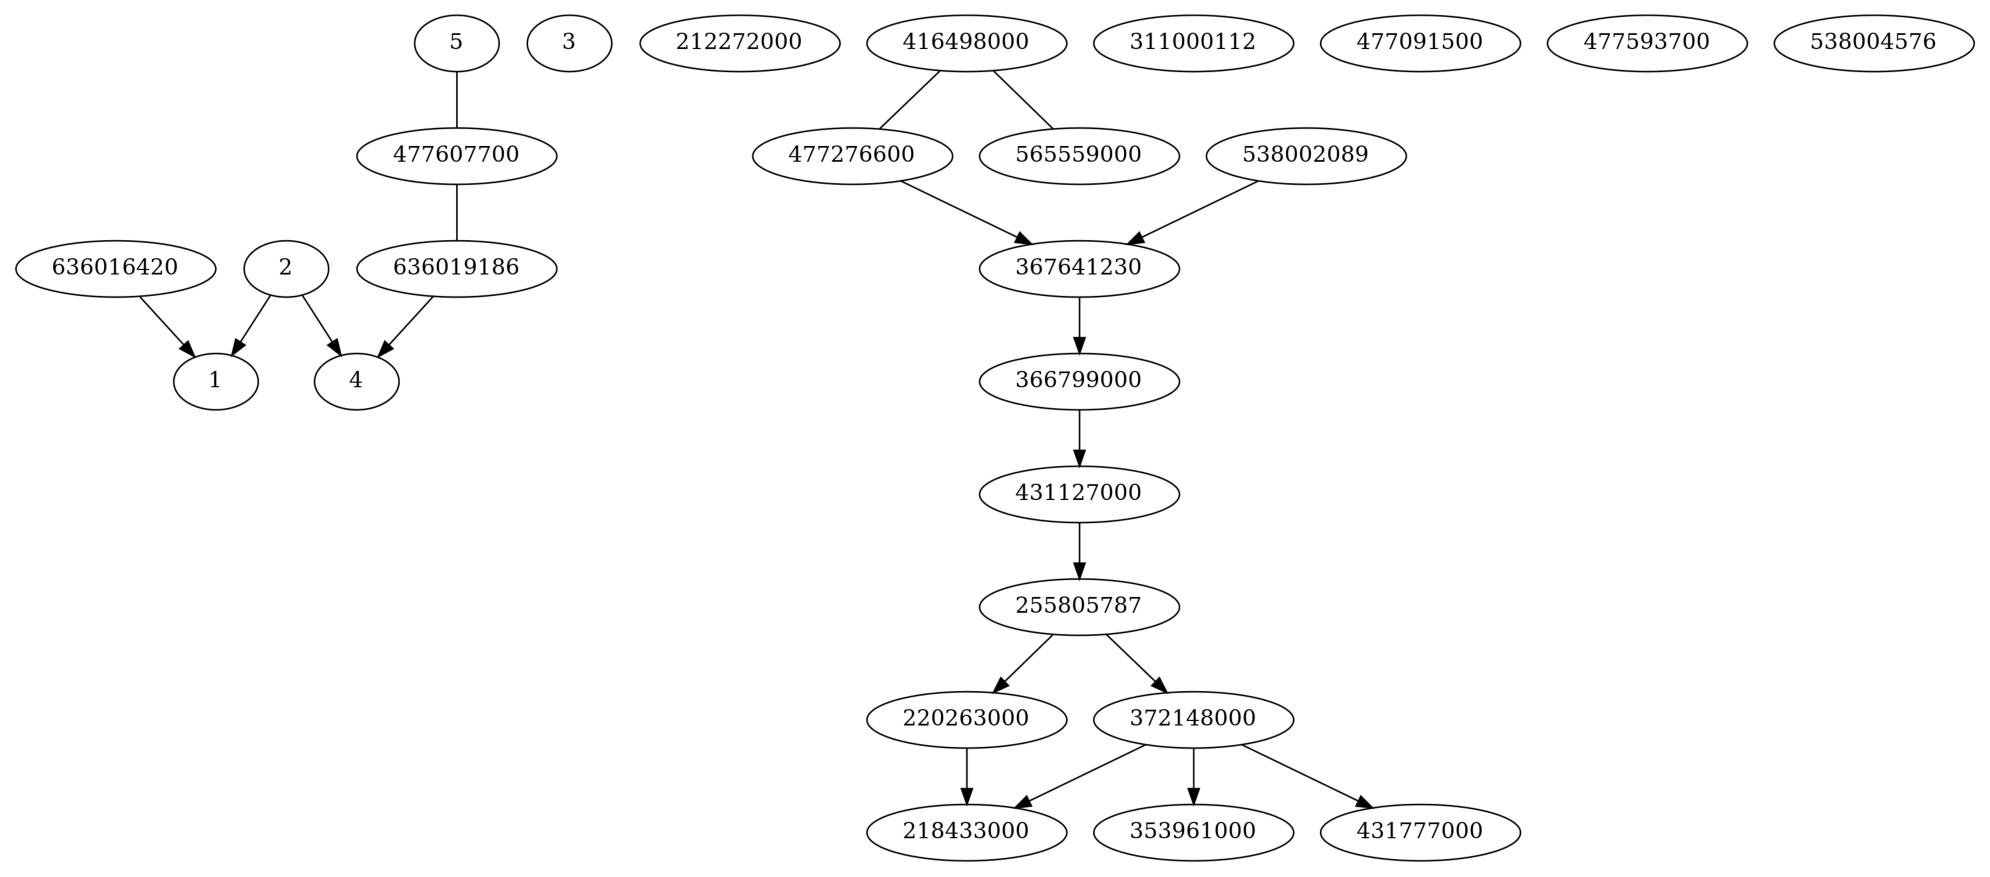

In [42]:
time_shift_ocean_data = time_shift_track(5, mmsi, 1, morning_ocean_data)
time_shift_ocean_data = time_shift_track(10, mmsi, 2, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(30, mmsi, 3, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(60, mmsi, 4, time_shift_ocean_data)
time_shift_ocean_data = time_shift_track(120, mmsi, 5, time_shift_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

## Timeshift Analysis Part II  
In this section we consider how far apart a track needs to be timewise in order for the graph to appear disconnected.

In [43]:
mmsi = 212272000

  0%|          | 0/22 [00:00<?, ?it/s]

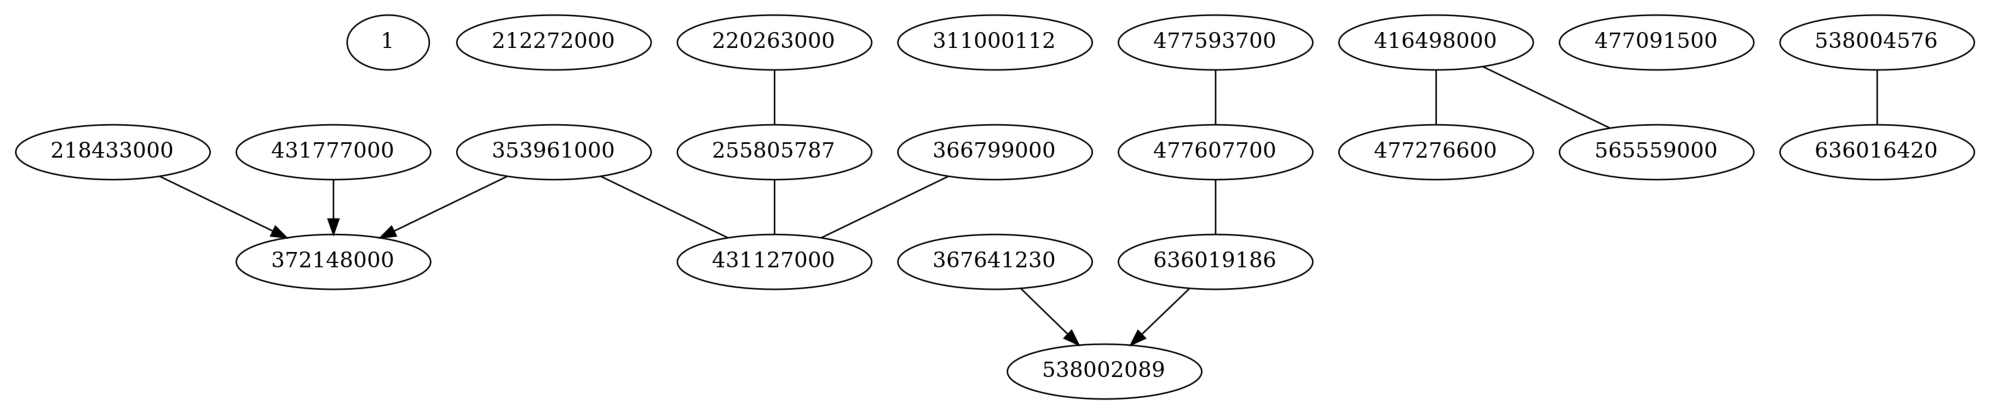

In [45]:
# Looking at 3 hours of time shift
time_shift_ocean_data = time_shift_track(180, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

With 3 hours of timeshift the duplicated track is independent of the original track.

  0%|          | 0/22 [00:00<?, ?it/s]

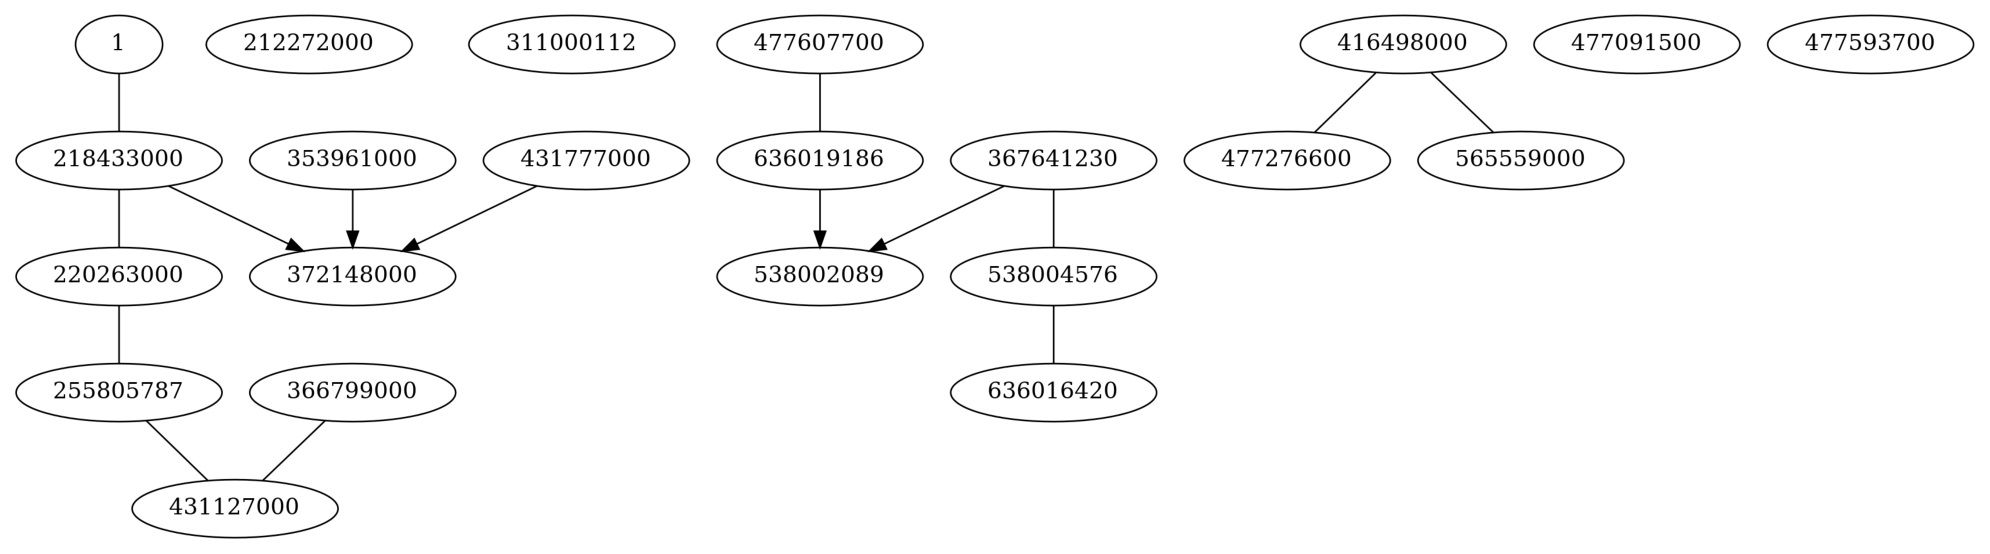

In [46]:
# Looking at 2 hours of time shift
time_shift_ocean_data = time_shift_track(120, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

The timeshifted track is connnected to other tracks, but still independent of the original track.

  0%|          | 0/22 [00:00<?, ?it/s]

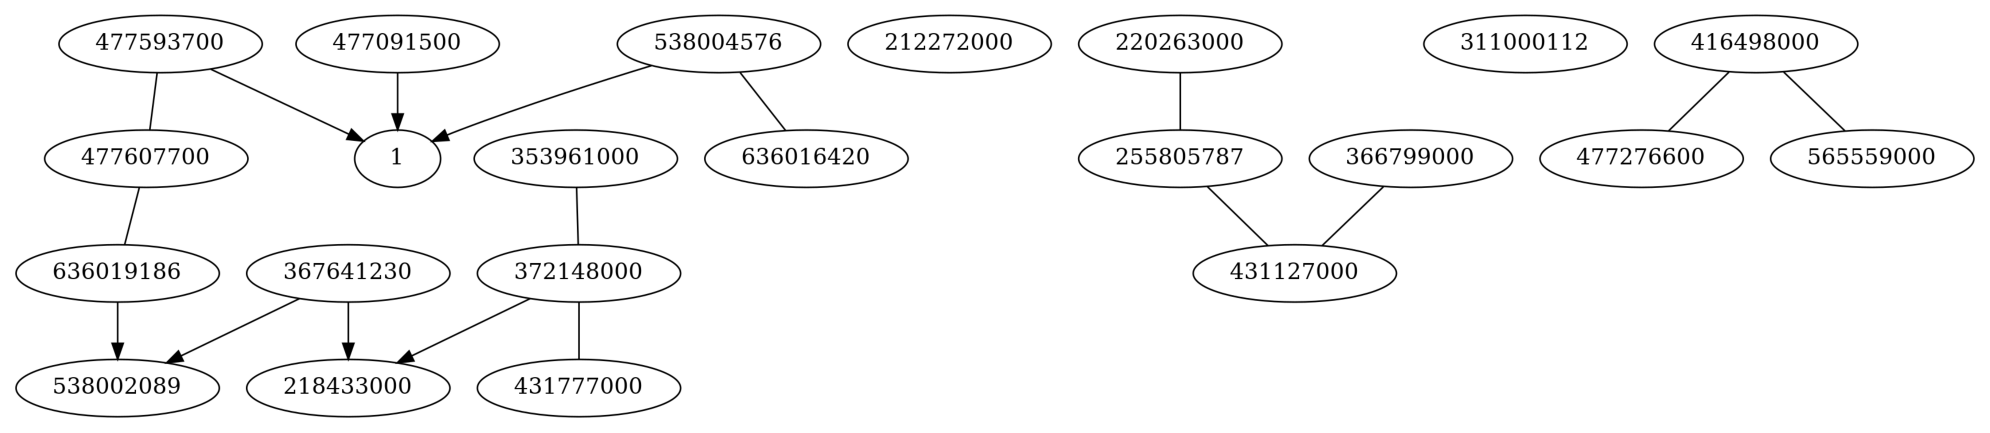

In [47]:
# Looking at 1 hour of time shift
time_shift_ocean_data = time_shift_track(60, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

The timeshifted track is connnected to other tracks, but still independent of the original track.

  0%|          | 0/22 [00:00<?, ?it/s]

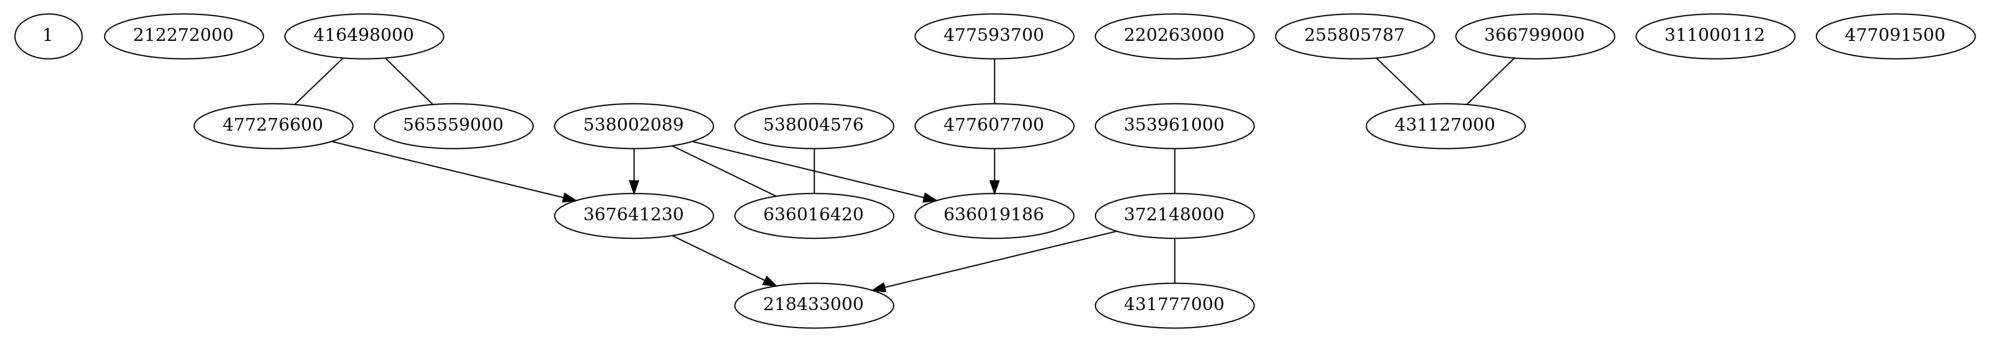

In [49]:
# Looking at 30 minutes of time shift
time_shift_ocean_data = time_shift_track(30, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

At 30 minutes, the timeshifted track is still independent of the original track.

  0%|          | 0/22 [00:00<?, ?it/s]

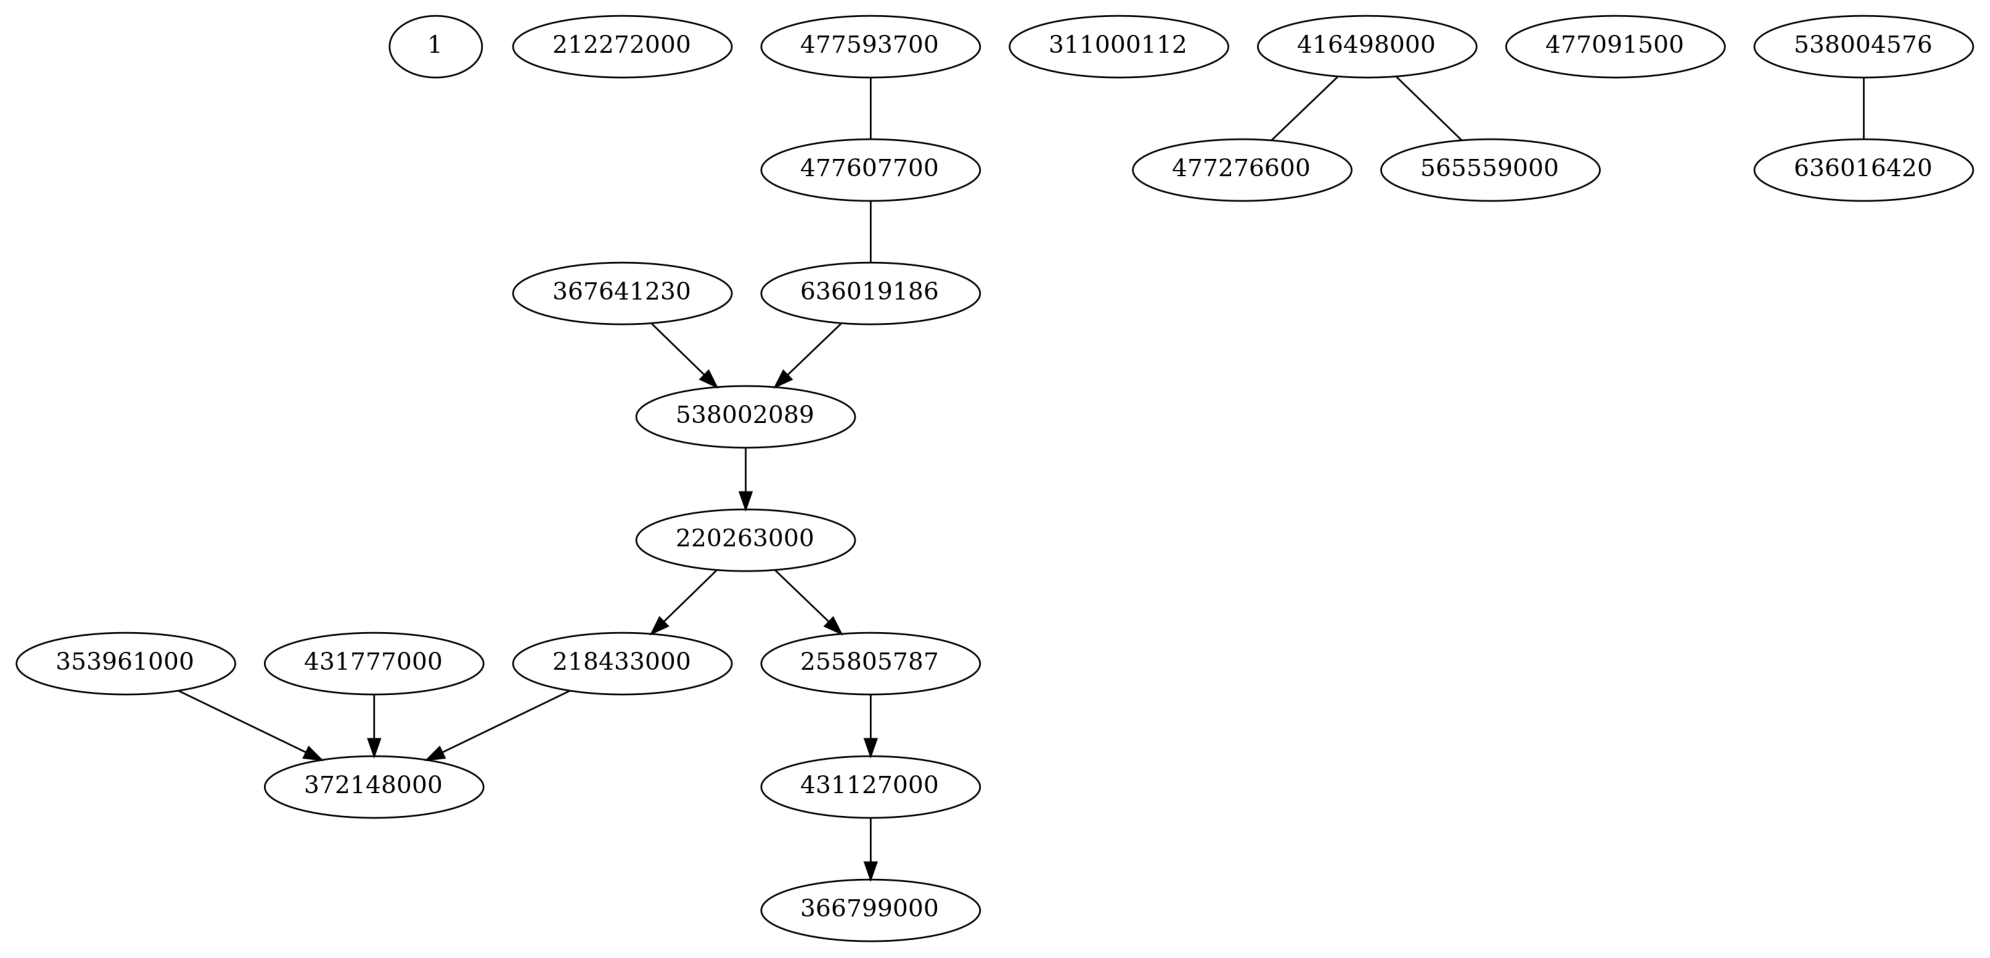

In [52]:
# Looking at 15 minutes of time shift
time_shift_ocean_data = time_shift_track(15, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

At 15 minutes, there is no connection between the original and timeshifted tracks.

  0%|          | 0/22 [00:00<?, ?it/s]

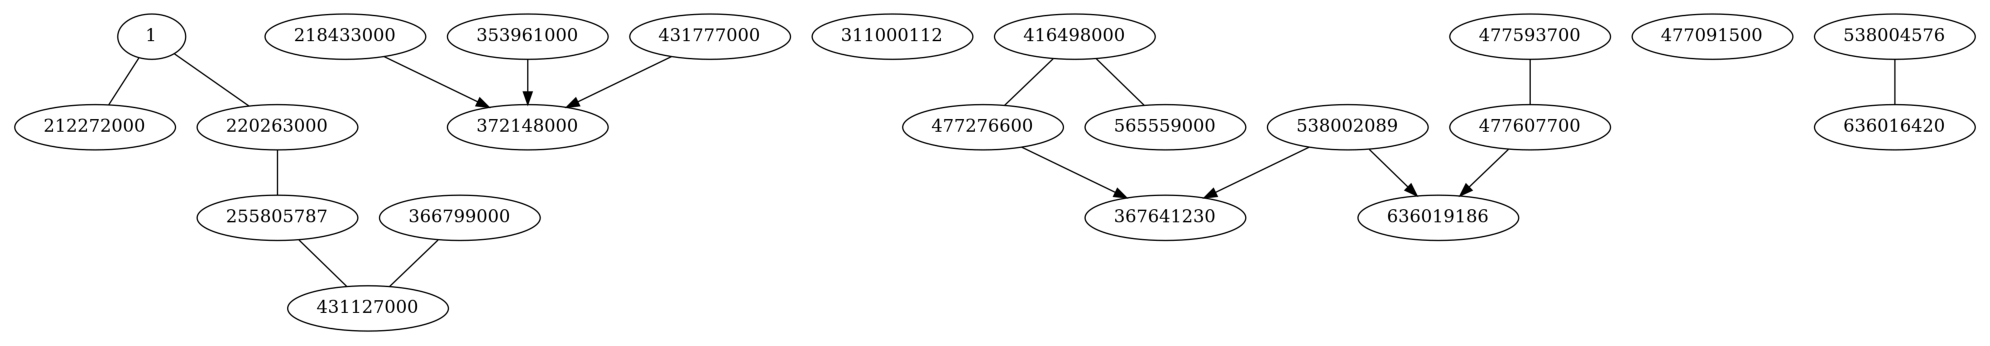

In [60]:
# Looking at 5 minutes of time shift
time_shift_ocean_data = time_shift_track(10, mmsi, 1, morning_ocean_data)

clean_data = clean_data_processor(time_shift_ocean_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

At 10 minutes of timeshift we finally see the a dependency between the original track and the timeshifted track. Interestingly, this also causes additional connections in the graph not previously seen.